In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point

In [4]:
from theano_models import (as_tensor_variable, total_size, clone, clone_all,
                           Merge, Flatten, Reparameterize, squareplus, squareplus_inv,
                           InvertibleModel,
                           inputting_references, outputting_references,
                           PooledRandomStreams,
                           get_profile)
from theano_models.util.theano_helpers import independent_subgraphs, list_random_sources
from theano_models.visualization import d3viz
from IPython.display import IFrame
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm
import theano_models.extra_models as em
import theano_models.postmaps as post
from theano_models.composing import normalizing_flow, variational_bayes

In [5]:
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
inputting_references.update(['to_be_randomized'])
inputting_references, outputting_references

({'flat',
  'inputs',
  'n_data',
  'noise',
  'parameters',
  'parameters_positive',
  'parameters_pvalues',
  'to_be_randomized'},
 {'kl_prior', 'logP', 'loglikelihood', 'norm_det', 'outputs'})

In [8]:
from schlichtanders.myobjects import NestedNamespace

In [9]:
pm.RNG = NestedNamespace(PooledRandomStreams(pool_size=int(5e8)), RandomStreams())

# Data

In [10]:
datafile = '../data/mnist.pkl.gz'
# Load data.        a                                                                                           

with gzip.open(datafile,'rb') as f:                                                                        
    train_set, val_set, test_set = cPickle.load(f)                                                       

X, Z = train_set                                                                                               
VX, VZ = val_set
TX, TZ = test_set

Z = one_hot(Z, 10)
VZ = one_hot(VZ, 10)
TZ = one_hot(TZ, 10)

image_dims = 28, 28

X, Z, VX, VZ, TX, TZ = [cast_array_to_local_type(i) for i in (X, Z, VX,VZ, TX, TZ)]
map(np.shape, [X, Z, VX, VZ, TX, TZ])

[(50000, 784),
 (50000, 10),
 (10000, 784),
 (10000, 10),
 (10000, 784),
 (10000, 10)]

# Model

## data modelling

In [11]:
input = as_tensor_variable(X[0], name="X")  # this is extremely useful to tell everything the default sizes
predictor = dm.Mlp(input=input, output_size=10, output_transfer="softmax", hidden_sizes=[300]*1, hidden_transfers=["rectifier"]*1)
# post.flatten_parameters(predictor)
predictor

Mlp { 'inputs': [X],
  'outputs': AffineNonlinear2.outputs,
  'parameters': [weights, bias, weights2, bias2]}

In [12]:
target_distribution = pm.Categorical(predictor)
target_distribution

Categorical { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f11f3aeb210 for function at 0x7f11f39c9758>,
  'outputs': Categorical.outputs,
  'parameters_pvalues': [AffineNonlinear2.outputs]}

In [13]:
targets = Merge(target_distribution, predictor,
                Flatten(predictor['parameters'], flat_key="to_be_randomized")) #givens={predictor['inputs'][0]: X[0]}
targets

Merge { 'inputs': [X],
  'logP': <FunctionWrapper at 0x7f11f3aeb210 for function at 0x7f11f39c9758>,
  'outputs': Categorical.outputs,
  'parameters': [],
  'parameters_pvalues': [],
  'to_be_randomized': "weights:bias:weights2:bias2"}

## parameter modelling

In [14]:
params_base = pm.DiagGauss(output_size=total_size(targets['to_be_randomized']))  
# if you want to use size directly, CAUTION, you need to copy before!
# params_base.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
params_base

DiagGauss { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f11dcd240c0 for function at 0x7f11dcfa2758>,
  'noise': [DiagGaussianNoise.noise.0],
  'outputs': DiagGaussianNoise.outputs,
  'parameters': [mean],
  'parameters_positive': [var]}

In [15]:
normflows = [dm.PlanarTransform() for _ in range(2)]
normflows

[PlanarTransform { 'inputs': [z],
   'norm_det': PlanarTransform.norm_det,
   'outputs': PlanarTransform.outputs,
   'parameters': [b, w, _u]}, PlanarTransform2 { 'inputs': [z2],
   'norm_det': PlanarTransform2.norm_det,
   'outputs': PlanarTransform2.outputs,
   'parameters': [b2, w2, _u2]}]

In [16]:
params = params_base
for transform in normflows:
    params = normalizing_flow(transform, params)  # returns transform, however with adapted logP    

params

normalized_flow2 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7f11dccf6210 for function at 0x7f11dcd1c230>,
  'noise': [DiagGaussianNoise.noise.0],
  'norm_det': PlanarTransform2.norm_det,
  'outputs': PlanarTransform2.outputs,
  'parameters': [b2, w2, _u2, b, w, _u, mean],
  'parameters_positive': [var]}

## bayes

In [17]:
prior = pm.Gauss(total_size(targets['to_be_randomized']))
prior = Merge(prior, parameters=None, parameters_positive='hyperparameters_positive')  # mean is not adapted at all, but left centred at zero
prior

Merge2 { 'hyperparameters_positive': [var2],
  'inputs': [],
  'logP': <FunctionWrapper at 0x7f11dccf6280 for function at 0x7f11dcca99b0>,
  'noise': [GaussianNoise.noise.0],
  'outputs': GaussianNoise.outputs,
  'parameters': []}

In [18]:
model = variational_bayes(targets, 'to_be_randomized', params, priors=prior)
model

variational_lower_bound { 'hyperparameters_positive': [var2],
  'inputs': [X],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7f11dccf6de0 for function at 0x7f11dccd4c08>,
  'loglikelihood': <FunctionWrapper at 0x7f11f3aeb210 for function at 0x7f11f39c9758>,
  'n_data': n_data,
  'noise': [DiagGaussianNoise.noise.0, GaussianNoise.noise.0],
  'norm_det': PlanarTransform2.norm_det,
  'outputs': Categorical.outputs,
  'parameters': [b2, w2, _u2, b, w, _u, mean],
  'parameters_positive': [var],
  'parameters_pvalues': []}

In [19]:
model = Merge(model, Reparameterize(model['parameters_positive'], squareplus, squareplus_inv))
model

Merge3 { 'hyperparameters_positive': [var2],
  'inputs': [X],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7f11dccf6de0 for function at 0x7f11dccd4c08>,
  'loglikelihood': <FunctionWrapper at 0x7f11f3aeb210 for function at 0x7f11f39c9758>,
  'n_data': n_data,
  'noise': [DiagGaussianNoise.noise.0, GaussianNoise.noise.0],
  'norm_det': PlanarTransform2.norm_det,
  'outputs': Categorical.outputs,
  'parameters': [b2, w2, _u2, b, w, _u, mean, var_squareplus],
  'parameters_positive': [],
  'parameters_pvalues': []}

In [20]:
model = Merge(model, Flatten(model['parameters']))
#               em.NoisePool(model['noise']) #, givens={predictor['inputs'][0]: X[0]}
model

Merge4 { 'flat': "b2:w2:_u2:b:w:_u:mean:var_squareplus",
  'hyperparameters_positive': [var2],
  'inputs': [X],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7f11dccf6de0 for function at 0x7f11dccd4c08>,
  'loglikelihood': <FunctionWrapper at 0x7f11f3aeb210 for function at 0x7f11f39c9758>,
  'n_data': n_data,
  'noise': [DiagGaussianNoise.noise.0, GaussianNoise.noise.0],
  'norm_det': PlanarTransform2.norm_det,
  'outputs': Categorical.outputs,
  'parameters': [],
  'parameters_positive': [],
  'parameters_pvalues': []}

# Optimizer

In [21]:
InvertibleModel.reduce_all_identities()

In [22]:
postmap = compose(post.flat_numericalize_postmap, post.variational_postmap)
postmap_kwargs = {
    'mapreduce': meanmap,
    'adapt_init_params': lambda ps: ps + np.random.normal(size=ps.size) * 0.01,
#     'profile': True,
    'mode': 'FAST_RUN'
}
optimizer_kwargs = postmap(model, **postmap_kwargs)
climin_kwargs = post.climin_postmap(optimizer_kwargs)
climin_kwargs

{'f': <function theano_models.postmaps.f>,
 'fprime': <function theano_models.postmaps.f>,
 'wrt': array([-0.00218234,  1.0112596 ,  0.99723244, ...,  1.00749209,
         0.99668477,  1.00182873])}

Climin wants an iterator of (args, kwarsg) as keyword argument "args" (to be passed to the loss function). Concretley, we use an infinite iterator over minibatches.

TODO write chunk with O(M) M=number of minibatches
the current implementation is O(N) N=number of samples, because of use of generators instead of list slicing

try to use ``chunk_gen``

In [23]:
batch_size = 200

In [24]:
climin_args = izip(izip(chunk(batch_size, cycle(Z)), chunk(batch_size, cycle(X))), repeat({}))
# climin_args = repeat(((Z[:10],X[:10]),{}))

In [25]:
opt = optimizer(
    identifier="adadelta",
    args=climin_args,
    **climin_kwargs
)

/home/stephan/GitProjects/breze/src/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adadelta.Adadelta'>
  % (i, klass))


# Visualized Fit

<IPython.core.display.Javascript object>


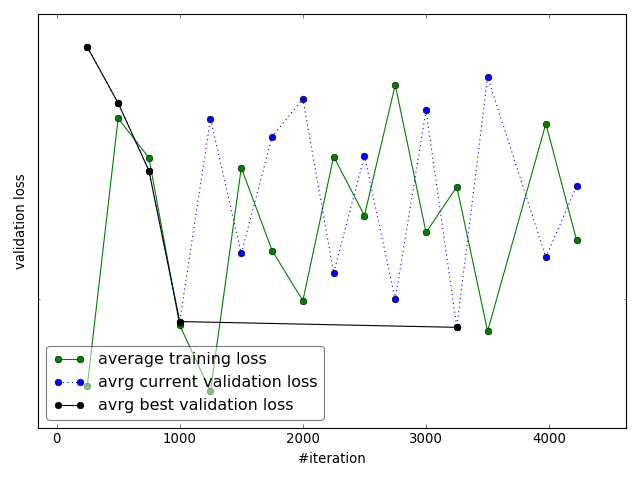

In [27]:
line_train, = plot([], [], 'go-', label="average training loss")
line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
ylabel("validation loss")
xlabel("#epoch")
legend(loc='lower left', fancybox=True, framealpha=0.5)

In [ ]:
best_val_loss = inf
best_wrt = None

In [ ]:
val_size = 10 #batch_size  # for testing inbetween how the performance goes

n_batches = X.shape[0] // batch_size  # after this many steps we went through the whole data set once
n_epochs = 600  # taken from UncertainWeightsPaper

for info in takeN(n_epochs, every(n_batches, opt)):
    # collect and visualize validation loss for choosing the best model
    current_epoch = info['n_iter']//n_batches
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, VZ[:val_size], VX[:val_size]) #/val_size
    if val_loss < best_val_loss:
        best_wrt = opt.wrt
        best_val_loss = val_loss
        add_point(line_best_val, current_epoch, val_loss)
    add_point(line_curr_val, current_epoch, val_loss)
    
    # visualize training loss for comparison:
    try:
        training_loss = info['loss'] #/ len(Z)  # TODO normalization needed?
    except KeyError:
        training_loss = optimizer_kwargs['num_loss'](opt.wrt, Z[:val_size], X[:val_size]) #/len(Z)
    add_point(line_train, current_epoch, training_loss)
    
    print info['n_iter'], training_loss, val_loss, best_val_loss

3973 314.924090812 303.492495472 297.676133154
4223

# Performance

TODO: average over predictions

In [ ]:
print best_val_loss
mlp['parameters_flat'] = best_wrt

predict = mlp.function()
predict(X[0]), Z[0]

In [ ]:
PX = np.apply_along_axis(predict, 1, X)
PVX = np.apply_along_axis(predict, 1, VX)
PTX = np.apply_along_axis(predict, 1, TX)

In [ ]:
print 'incorrect samples train/val/test:  %i/%i/%i' % (
    (PX[:, :10].argmax(1) != Z.argmax(1)).sum(),
    (PVX[:, :10].argmax(1) != VZ.argmax(1)).sum(),
    (PTX[:, :10].argmax(1) != TZ.argmax(1)).sum())

print 'error rate train/val/test:  %g/%g/%g' % (
    (PX[:, :10].argmax(1) != Z.argmax(1)).mean(),
    (PVX[:, :10].argmax(1) != VZ.argmax(1)).mean(),
    (PTX[:, :10].argmax(1) != TZ.argmax(1)).mean())